## **<span style="color:orange;">Import Libraries</span>**

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import math
import sklearn
import warnings

from sklearn.model_selection import train_test_split
from feature_engine.transformation import LogTransformer, BoxCoxTransformer, YeoJohnsonTransformer
from feature_engine.selection import DropConstantFeatures
from sklearn.preprocessing import PowerTransformer, StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from feature_engine.encoding import RareLabelEncoder

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import QuantileRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from feature_engine.selection import (
    DropConstantFeatures,
    DropCorrelatedFeatures
)

from feature_engine.creation import MathFeatures

from sklearn_quantile import (
    SampleRandomForestQuantileRegressor,
    SampleExtraTreesQuantileRegressor
)

from sklearn.metrics import (
    mean_pinball_loss,
    d2_pinball_score
)

In [46]:
pd.set_option('display.max_columns', None)
sklearn.set_config(transform_output='pandas')
warnings.filterwarnings("ignore")

## **<span style="color:orange;">Reading Data</span>**

In [47]:
# Function to read data from source
def get_data():
    BASE_DIR = Path.cwd().parents[0]
    file_name = 'claims-severity-anonymized-raw.csv'
    return pd.read_csv(BASE_DIR / 'data' / 'allstate-claims-severity' / file_name, on_bad_lines="skip")

In [48]:
# Reading data from source
df = get_data()

In [49]:
# Applying removing null values
df = df.dropna(axis=0, ignore_index=True).drop('id', axis=1)

In [50]:
# Preview of data
df.head(5)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,D,D,B,D,C,B,D,B,A,A,A,A,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,A,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,B,D,B,D,C,B,B,B,A,A,A,A,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,D,D,D,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,B,D,B,B,C,B,B,C,A,A,A,B,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [51]:
# List of Categorical Features
cat_cols = df.select_dtypes(include='O').columns.to_list()

# List of Numerical Features
num_cols = df.select_dtypes(include=float).columns.to_list()
num_cols.remove('loss')

print(cat_cols)
print("="*100)
print(num_cols)

['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat110', 'cat111

In [52]:
df.head(5)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,D,D,B,D,C,B,D,B,A,A,A,A,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,A,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,B,D,B,D,C,B,B,B,A,A,A,A,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,D,D,D,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,B,D,B,B,C,B,B,C,A,A,A,B,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


##### <span style="color:orange;">Train-Test Split</span>

In [53]:
# Independent variables
X = df.drop("loss", axis=1)

# Dependent variable
y = df["loss"]

# Train + Temp split
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,      # 30% -> val + test
    random_state=42,
    shuffle=True
)

# Validation + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,      # split 30% into 15% val, 15% test
    random_state=42,
    shuffle=True
)

In [54]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(131822, 130)
(28248, 130)
(28248, 130)


In [55]:
drop_constant = DropConstantFeatures(tol=0.99, variables=cat_cols)

X_train = drop_constant.fit_transform(X_train)
X_val  = drop_constant.transform(X_val)
X_test = drop_constant.transform(X_test)

In [56]:
drop_corr = DropCorrelatedFeatures(variables=num_cols)

X_train = drop_corr.fit_transform(X_train)
X_val  = drop_corr.transform(X_val)
X_test = drop_corr.transform(X_test)

In [57]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(131822, 95)
(28248, 95)
(28248, 95)


In [58]:
input_cat = X_train.select_dtypes(include='O').columns.to_list()

In [59]:
rare = RareLabelEncoder(
    max_n_categories=5,
    replace_with='Other',
    variables=input_cat,
    missing_values='raise'
)

X_train = rare.fit_transform(X_train, y_train)
X_val = rare.transform(X_val)
X_test = rare.transform(X_test)
print("Completed")

Completed


##### <span style="color:orange;">Catboost</span>

In [60]:
train_pool = Pool(
    X_train,
    y_train,
    cat_features=input_cat
)

valid_pool = Pool(
    X_val,
    y_val,
    cat_features=input_cat
)

test_pool = Pool(
    X_test,
    y_test,
    cat_features=input_cat
)

In [69]:
q = 0.90  # quantile

cat_model = CatBoostRegressor(
    loss_function=f"Quantile:alpha={q}",
    eval_metric=f"Quantile:alpha={q}",

    iterations=800,
    learning_rate=0.05,
    depth=4,

    l2_leaf_reg=7,

    random_seed=42,
    early_stopping_rounds=5,
    one_hot_max_size=5,
)


cat_model.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 646.3042229	test: 645.3672033	best: 645.3672033 (0)	total: 259ms	remaining: 3m 26s
1:	learn: 628.2316648	test: 627.8163748	best: 627.8163748 (1)	total: 600ms	remaining: 3m 59s
2:	learn: 611.9347245	test: 611.8174338	best: 611.8174338 (2)	total: 855ms	remaining: 3m 47s
3:	learn: 597.5821029	test: 597.5979114	best: 597.5979114 (3)	total: 1.08s	remaining: 3m 34s
4:	learn: 584.3597741	test: 584.7248371	best: 584.7248371 (4)	total: 1.34s	remaining: 3m 33s
5:	learn: 572.1046038	test: 572.5773210	best: 572.5773210 (5)	total: 1.53s	remaining: 3m 21s
6:	learn: 560.7250666	test: 561.4675373	best: 561.4675373 (6)	total: 1.68s	remaining: 3m 10s
7:	learn: 550.4580349	test: 551.5073209	best: 551.5073209 (7)	total: 1.91s	remaining: 3m 8s
8:	learn: 541.3286901	test: 542.4055822	best: 542.4055822 (8)	total: 2.09s	remaining: 3m 3s
9:	learn: 532.0376801	test: 533.2519689	best: 533.2519689 (9)	total: 2.43s	remaining: 3m 12s
10:	learn: 523.9565851	test: 525.1656095	best: 525.1656095 (10)	total: 2

In [70]:
def get_metrics(model, X_test, y_test, quantile: float = 0.9):
        # Predictions
        y_pred = model.predict(X_test)

        # Mean pinball loss
        pinball = mean_pinball_loss(
            y_test,
            y_pred,
            alpha=quantile
        )

        # D² pinball score
        d2 = d2_pinball_score(
            y_test,
            y_pred,
            alpha=quantile
        )

        # Coverage
        coverage = (y_test <= y_pred).mean()

        metrics = {
            "pinball_loss": pinball,
            "d2_pinball": d2,
            "coverage": coverage
        }

        return metrics

In [71]:
get_metrics(cat_model , X_test, y_test, quantile=0.9)

{'pinball_loss': 347.86385522010266,
 'd2_pinball': 0.46879704527908017,
 'coverage': np.float64(0.8981874822996319)}

In [72]:
{'pinball_loss': 346.34552326505593,
 'd2_pinball': 0.47111560298108024,
 'coverage': np.float64(0.8977980741999434)}

{'pinball_loss': 346.34552326505593,
 'd2_pinball': 0.47111560298108024,
 'coverage': np.float64(0.8977980741999434)}

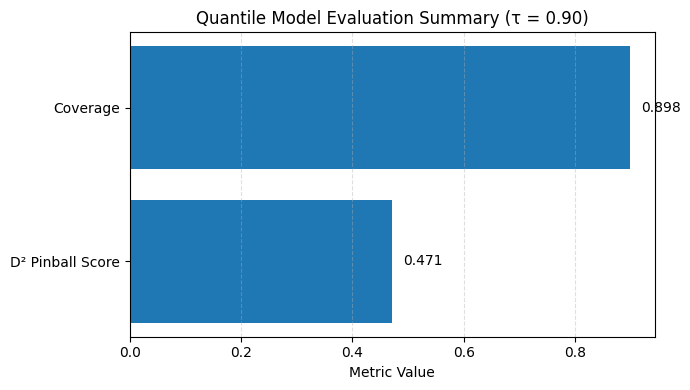

In [73]:
# Metrics
metrics = {
    "D² Pinball Score": 0.471,
    "Coverage": 0.898
}

names = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize=(7, 4))

bars = plt.barh(names, values)

# Annotate values
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.02,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.3f}",
        va="center",
        fontsize=10
    )

plt.title("Quantile Model Evaluation Summary (τ = 0.90)", fontsize=12)
plt.xlabel("Metric Value")
plt.grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


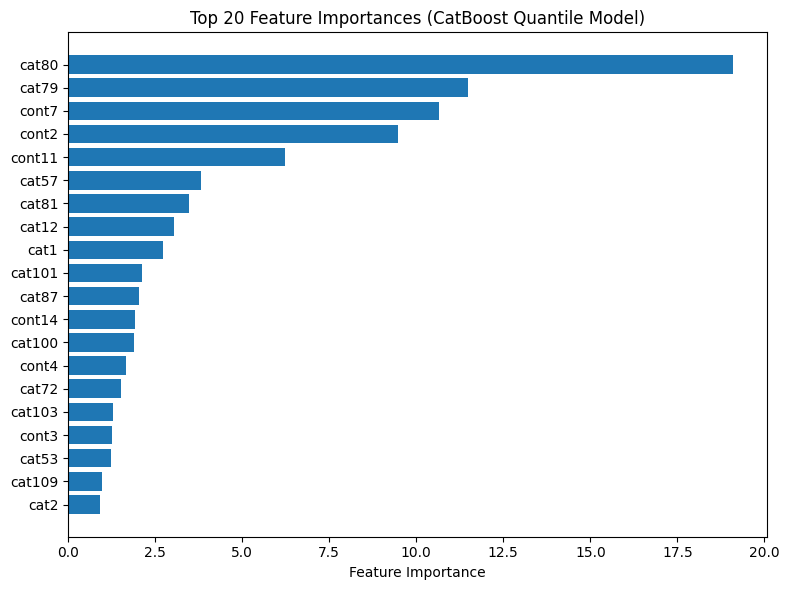

In [74]:
# Get feature names
feature_names = cat_model.feature_names_

# Get feature importances
importances = cat_model.feature_importances_

# Create DataFrame
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

# Sort and select top 20
fi_top20 = (
    fi_df
    .sort_values("importance", ascending=False)
    .head(20)
    .sort_values("importance")   # sort again for horizontal plot
)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(fi_top20["feature"], fi_top20["importance"])
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances (CatBoost Quantile Model)")
plt.tight_layout()
plt.show()